In [1384]:
import pandas as pd
from shutil import copyfileobj
from urllib import request 
import requests as rq
import uuid
import xlwings as xw
import re
from bs4 import BeautifulSoup
import csv
import datetime
from unidecode import unidecode
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)

In [1377]:
# lecture/écriture d'un fichier Excel avec xlwings
def save_with_xlwings(file,savename):
    tempfile = f'{savename}.xlsx'
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile  


def List(html):
    ##fonction qui extrait sous forme de liste toutes les dates de publications des classements##
    soup=BeautifulSoup(html)
    m=soup.find_all('option')
    L=[]
    for i,l in enumerate(m):
        if i>0:
            L.append(l['value'])
    return L



def clean_excel(date,files):
    ##préparation des données issue d'un tableau excel## 
    
    #on utilise la variable files afin de faire correspondre la date fournis avec le nom complet du fichier correspondant.
    Tmp=pd.read_excel(files[date],header=(3))
    
    #on supprime la première ligne qui contient les noms des sous colonnes dans le fichier excel
    #on supprime les entrées qui correspondent à des blanc dans le fichier excel et sont donc luent comme des NaN
    Tmp2=Tmp.drop(['Unnamed: 0'],axis=1).drop([0,34,35,36,37],axis=0)  
    
    #on gère les sous colonnes du fichier excel en leurs attribuant des colonnes propre dans les DataFrame.
    columns=['Rang','Nat / Voile','Bateau/Skipper','Actu Heure FR','Actu Latitude','Actu Longitude',
             '30 min Cap','30 min Vitesse','30 min VMG','30 min Distance',
             'DerCl Cap','DerCl Vitesse','DerCl VMG','DerCl Distance',
             '24h Cap','24h Vitesse','24h VMG','24h Distance',
             'DTF','DTL'
            ]
    Tmp2.columns=columns
    
    #on normalise les noms des Skippers afin de pouvoir effectuer des jointures avec d'autre DataFrame.
    Tmp2['Bateau/Skipper']=Tmp2['Bateau/Skipper'].apply(norm_nom_class)
    return Tmp2

def norm_nom_class(nom):
    ##fonction qui normalise le nom du skipper en vue des différentes jointures à effectuer##
    
    #on récupère tout ce qui se trouve avant le signe de passage à la ligne
    h=re.compile('([a-zA-ZÀ-ÿ ]+)(?:\n)')
    
    #on supprime les accents des prénom et écrit tout en minuscule
    return unidecode(h.search(nom).groups()[0].lower())

def colprep_24(string):
    ##prépare la colonne 24h VMG pour l'analyse de donné##
    
    #suppréssion de l'unité dans les champs du data frame
    p=re.compile('[0-9.]+')
    no_unit=p.search(string).group()
    
    #convertis le format string en format float
    return float(no_unit)

def clean_Rang(string):
    ##fonction utilisé pour reformater la colonne Rang du dernier classement##

    #on utilise une RegEx pour extraire le classement et se débarasser de l'inscription ARV

    p=re.compile('[0-9]+')
    return int(p.search(string).group())

## Scrapping et préparation des tableaux excel
La cellule de scrapping met 30min à tourner, à utiliser avec parcimonie

In [ ]:
# Extraction du code html du site
url='https://www.vendeeglobe.org/fr/classement'
r=rq.get(url)
html=r.content.decode('utf-8')

#extraction des dates de publications des classement
L=List(html) 

#dossier qui permets de ne pas ouvir excel lors du traitement de chaque fichier scrappé
magicfolder='/Users/Bourtguize-Ramel/Library/Group Containers/UBF8T346G9.Office/MyExcelFolder'

#dictionnaire qui contiendra les noms complets des fichier en fonction des dates afin de pouvoir les charger facilement
files={}
for date in L:
    #url qui lance un téléchargement
    url=f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{date}.xlsx'
    
    #nom complet des fichiers pour leurs sauvegarde dans le dossier magicfolder
    filename = f'{magicfolder}/ExcelFromSite/{date}.xlsx'
    
    #scrapping des fichier excel
    with request.urlopen(url) as response, open(filename, 'wb') as out_file:
        copyfileobj(response, out_file)
    save_with_xlwings(filename,f'{magicfolder}/XLWINGS/{date}_XLWGS')
    
    files[date]=f'{magicfolder}/XLWINGS/{date}_XLWGS.xlsx' 

On sauvegarde la variables files qui fait le lien entre les dates et l'emplacement des fichiers.

In [487]:
w = csv.writer(open("files_loc.csv", "w"))
for key, val in files.items():
    w.writerow([key, val])
    
#Code pour recréé la variable files sous forme de dictionnaire.

#with open('files_loc.csv') as f:
#    reader = csv.reader(f)
#    result = dict(reader)


On note que le format des fichiers excel ne change pas entre le 2020-11-08 14:00:00 et le 2021-01-27 14:00:00 inclus.

On présente le résultat de la préparation des fichiers importés pour une date dans cet interval

In [1385]:
ExClean=clean_excel('20201109_210000',files)
ExClean

,Rang,Nat / Voile,Bateau/Skipper,Actu Heure FR,Actu Latitude,Actu Longitude,30 min Cap,30 min Vitesse,30 min VMG,30 min Distance,DerCl Cap,DerCl Vitesse,DerCl VMG,DerCl Distance,24h Cap,24h Vitesse,24h VMG,24h Distance,DTF,DTL
1,1,\nFRA 1000,damien seguin,22:30 FR\n,44°05.82'N,08°29.60'W,209°,8.0 kts,8.0 kts,4.0 nm,209°,9.8 kts,9.8 kts,44.0 nm,235°,8.8 kts,8.8 kts,210.6 nm,23988.6 nm,0.0 nm
2,2,\nFRA 6,nicolas troussel,22:30 FR\n,44°29.42'N,09°33.80'W,177°,13.6 kts,12.4 kts,6.8 nm,191°,13.2 kts,12.9 kts,59.2 nm,239°,9.0 kts,7.6 kts,215.9 nm,23992.6 nm,4.0 nm
3,3,\nFRA 01,jean le cam,22:30 FR\n,44°17.87'N,08°44.88'W,205°,9.8 kts,9.8 kts,4.9 nm,208°,11.1 kts,11.0 kts,49.9 nm,243°,8.8 kts,7.2 kts,211.6 nm,23995.1 nm,6.4 nm
4,4,\nFRA 8,jeremie beyou,22:30 FR\n,44°38.54'N,09°55.16'W,193°,13.2 kts,13.0 kts,6.6 nm,205°,14.0 kts,14.0 kts,63.1 nm,244°,9.4 kts,7.5 kts,225.0 nm,23995.6 nm,7.0 nm
5,5,\nFRA 53,maxime sorel,22:30 FR\n,44°20.30'N,08°47.03'W,205°,7.9 kts,7.9 kts,4.0 nm,212°,10.4 kts,10.3 kts,46.9 nm,238°,8.8 kts,7.6 kts,212.4 nm,23996.7 nm,8.1 nm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,29,\nFRA 72,alexia barrier,22:30 FR\n,45°21.77'N,08°12.51'W,225°,9.7 kts,9.0 kts,4.8 nm,218°,9.6 kts,9.3 kts,43.2 nm,252°,7.7 kts,5.6 kts,185.7 nm,24062.9 nm,74.3 nm
30,30,\nFRA 14,arnaud boissieres,22:30 FR\n,45°30.78'N,08°32.30'W,223°,9.5 kts,8.9 kts,4.7 nm,209°,9.2 kts,9.2 kts,41.5 nm,252°,7.7 kts,5.5 kts,185.4 nm,24065.9 nm,77.2 nm
31,31,\nJPN 11,kojiro shiraishi,22:30 FR\n,45°45.38'N,09°21.76'W,210°,9.8 kts,9.7 kts,4.9 nm,216°,9.6 kts,9.3 kts,43.3 nm,260°,8.3 kts,5.0 kts,198.1 nm,24066.5 nm,77.9 nm
32,32,FR\nFRA 69,sebastien destremau,22:30 FR\n,45°37.98'N,08°20.32'W,232°,8.5 kts,7.4 kts,4.2 nm,218°,8.3 kts,8.0 kts,37.4 nm,259°,7.8 kts,4.9 kts,186.9 nm,24075.7 nm,87.1 nm


On pourrait pousser encore plus loin la préparation des données en précisant les unités des colonnes dans leurs entête, permettant ainsi de transformer certaines colonnes textuelles en colonnes numériques. On affinera la préparation au file de l'eau en fonction des besoins. On a toutesfois pris soin de transformer la colonne 'Bateau/Skipper' en prévision de la jointure avec le data frame des caractéristiques des bateaux. 

## Scrapping et préparation des donnés relatives aux charactéristiques technique des bateaux

In [1397]:
#récupération du code html de la page glossaire
url='https://www.vendeeglobe.org/fr/glossaire'
r=rq.get(url)
html=r.content.decode('utf-8')

#parsing du code html
soup=BeautifulSoup(html)

#list de dictionnaire, chaque dictionnaire correspond à un Skipper
carac=[]

l=soup.find_all('div',"boats-list__popup-infos")
for q in l:
    
    #extraction des caractéristiques techniques
    m=q.find('ul',{'class' : "boats-list__popup-specs-list"})
    p=re.compile(r'(.+)\n')
    ll=p.findall(m.text)
    spec={}
    for line in ll :
        p=re.compile('( : )')
        k=p.search(line)
        spec[line[0:k.span()[0]]]=line[k.span()[1]:len(line)]
        
    #extraction et formatage des noms des skippers en vue de futures jointures   
    z=re.compile('([^0-9/]+)')
    HiddenName=q.find('a').attrs['href'][13:]
    HiddenName2=z.search(HiddenName).group()
    w=re.compile('-+')
    spec['Skipper']=w.sub(' ',HiddenName2)
    carac.append(spec)
Cara=pd.DataFrame(carac)
Cara

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Skipper
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2,fabrice amedeo
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2,romain attanasio
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2,alexia barrier
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,yannick bestaven
4,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2,jeremie beyou
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,4,NaN,Juan Kouyoumdjian,CDK Technologies / Assemblage : Team ARKEA PAPREC,19 Juillet 2019,"18,28 m","5,70 m","4,50 m",8 t,foiler,29 m,Inox usiné,260 m2,600 m2,sebastien simon
30,FRA53,"Le Souffle du Nord, Groupe Bel",Verdier - VPLP,"Indiana Yachting (Scarlino, Italie)",07 Septembre 2007,"18,28 m","5,50 m","4,50 m","7,7 t",2,29 m,acier,365 m2,700 m2,maxime sorel
31,GBR 99,NaN,VPLP - Alex Thomson Racing (led by Pete Hobson),Carrington Boats,15 Août 2019,"18,28 m","5,40 m","4,50 m","7,7 t",foils,29 m,acier forgé,330 m2,630 m2,alex thomson
32,2,NaN,Samuel Manuard,Black Pepper©,31 Janvier 2020,"18,28 m","5,50 m","4,50 m","7,8 t",foils,28 m,acier forgé,270 m2,535 m2,armel tripon


Samantha Davies est appellé sam davies dans la page glossaire. On doit mettre son nom complet pour pouvoir faire une jointure par la suite.

In [1387]:
Cara['Skipper'][Cara['Skipper']=='sam davies']='samantha davies'

La ligne 16 correspond au skipper Francois-Guiffant mais il n'apparait pas dans les classement excel, c'est donc la ligne en trop (33 ligne dans les classements contre 34 dans le data frame des caractériques voilié)

In [ ]:
Cara1=Cara.drop(labels=16,axis=0)
Cara1=Cara1.reset_index(drop=True)

In [1388]:
Cara1.columns

Index(['Numéro de voile', 'Anciens noms du bateau', 'Architecte', 'Chantier',
       'Date de lancement', 'Longueur', 'Largeur', 'Tirant d'eau',
       'Déplacement (poids)', 'Nombre de dérives', 'Hauteur mât',
       'Voile quille', 'Surface de voiles au près',
       'Surface de voiles au portant', 'Skipper'],
      dtype='object')

Les colonnes qui nous intéressent sont celles lié aux caractéristiques techniques, on supprime donc les autres

In [1389]:
Caract=Cara1.drop(['Anciens noms du bateau','Architecte','Chantier','Date de lancement','Numéro de voile'],axis=1)
Caract

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Skipper
0,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2,fabrice amedeo
1,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2,romain attanasio
2,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2,alexia barrier
3,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,yannick bestaven
4,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2,jeremie beyou
...,...,...,...,...,...,...,...,...,...,...
28,"18,28 m","5,70 m","4,50 m",8 t,foiler,29 m,Inox usiné,260 m2,600 m2,sebastien simon
29,"18,28 m","5,50 m","4,50 m","7,7 t",2,29 m,acier,365 m2,700 m2,maxime sorel
30,"18,28 m","5,40 m","4,50 m","7,7 t",foils,29 m,acier forgé,330 m2,630 m2,alex thomson
31,"18,28 m","5,50 m","4,50 m","7,8 t",foils,28 m,acier forgé,270 m2,535 m2,armel tripon


Même remarque concernant la présentation des données que pour le données de classement : on affinera en fonction des besoins.

## Rapprochement des deux tables
On effectue une jointure entre un Data Frame issue des tables de classement et le Data Frame des caractéristiques bateau. On effecue la jointure sur les noms des Skipper.

In [1390]:
Join=TestClean.set_index('Bateau/Skipper').join(Caract.set_index('Skipper'),lsuffix='l')
Join

,Rang,Nat / Voile,Actu Heure FR,Actu Latitude,Actu Longitude,30 min Cap,30 min Vitesse,30 min VMG,30 min Distance,DerCl Cap,...,DTL,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
Bateau/Skipper,,,,,,,,,,,,,,,,,,,,,
damien seguin,1,\nFRA 1000,22:30 FR\n,44°05.82'N,08°29.60'W,209°,8.0 kts,8.0 kts,4.0 nm,209°,...,0.0 nm,"18,28 m","5,85 m","4,50 m","8,5 t",2,29 m,acier forgé,350 m2,610 m2
nicolas troussel,2,\nFRA 6,22:30 FR\n,44°29.42'N,09°33.80'W,177°,13.6 kts,12.4 kts,6.8 nm,191°,...,4.0 nm,"18,28 m","5,70 m","4,50 m","7,9 t",foils,"27,30 m",NaN,270 m2,535 m2
jean le cam,3,\nFRA 01,22:30 FR\n,44°17.87'N,08°44.88'W,205°,9.8 kts,9.8 kts,4.9 nm,208°,...,6.4 nm,"18,28 m","5,90 m","4,50 m",8 t,2,28 m,acier forgé,300 m2,620 m2
jeremie beyou,4,\nFRA 8,22:30 FR\n,44°38.54'N,09°55.16'W,193°,13.2 kts,13.0 kts,6.6 nm,205°,...,7.0 nm,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
maxime sorel,5,\nFRA 53,22:30 FR\n,44°20.30'N,08°47.03'W,205°,7.9 kts,7.9 kts,4.0 nm,212°,...,8.1 nm,"18,28 m","5,50 m","4,50 m","7,7 t",2,29 m,acier,365 m2,700 m2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
alexia barrier,29,\nFRA 72,22:30 FR\n,45°21.77'N,08°12.51'W,225°,9.7 kts,9.0 kts,4.8 nm,218°,...,74.3 nm,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
arnaud boissieres,30,\nFRA 14,22:30 FR\n,45°30.78'N,08°32.30'W,223°,9.5 kts,8.9 kts,4.7 nm,209°,...,77.2 nm,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
kojiro shiraishi,31,\nJPN 11,22:30 FR\n,45°45.38'N,09°21.76'W,210°,9.8 kts,9.7 kts,4.9 nm,216°,...,77.9 nm,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier forgé,320 m2,580 m2


## Analyse
On se propre d'analyser la pertinence du tracé de navigation théorique sur lesquelles sont projeté les vitesse des différents skipper. Cette projection produit la variable VMG. En toutes logique les Skipper qui réussisent à suivre ce tracé et à le parcourir le plus vite possible devraient arriver en premier. On devrait donc trouver que la somme des VMG des skippers est directement corrélé à leurs classement.

On extrait la liste des noms des skippers qui ont terminé la course 

In [1414]:
#L[0] correspond au dernier classement publié
df=clean_excel(L[0],files)
#liste des skippers arrivés 
Arr=pd.DataFrame(df[df['Rang']!='RET'][['Rang','Bateau/Skipper']])
arr=Arr['Bateau/Skipper']
arr                                           

1     yannick bestaven
2        charlie dalin
3         louis burton
4          jean le cam
5       boris herrmann
            ...       
21      clement giraud
22      miranda merron
23       manuel cousin
24      alexia barrier
25         ari huusela
Name: Bateau/Skipper, Length: 25, dtype: object

In [1415]:
# initialisation du dataframe qui vas contenir le cumul des VGM 
DF=pd.DataFrame(np.zeros(len(arr)),index=arr.values,columns=['VMGc'])    
DF

,VMGc
yannick bestaven,0.0
charlie dalin,0.0
louis burton,0.0
jean le cam,0.0
boris herrmann,0.0
...,...
clement giraud,0.0
miranda merron,0.0
manuel cousin,0.0
alexia barrier,0.0


Trois relevés de VMG sont proposés : un qui retrace les 30 dernières minutes, un calculé depuis le dernier classement publié et enfin un qui se concentre sur les dernières 24h. On remarque que les intervals de temps utilisés pour le calcul se chevauches. Si on se restreind à la mesure qui moyenne les dernières 24h et qu'on la lis sur des classements publiés à 24h d'écart, on obtient un relevé journalié, également espacé et sans chevauchements des VMG. On peut donc approximer le cumul des VMG tout au long de la course par le cumul de ces mesures et comparer les valeurs au classement final.

On se fixe sur les relevé publié à 14:00:00 chaque jours

On ne peut pas prendre en compte le classement du 2020-11-08 14: 00 : 00 car un des skipper qui a finit la course (Charlie Dalin) n'est pas classé ce jour là (catégoriser comme NL).

In [1416]:
for i in range(L.index('20210127_140000'),L.index('20201108_140000')):
    if(L[i][9:11]=='14'):
        tmp=clean_excel(L[i],files)
        #on ne garde que les relevé des Skippers qui ont terminé la course
        VGMtmp=tmp[tmp['Bateau/Skipper'].isin(arr)][['Bateau/Skipper','24h VMG']]
        VGMtmp=VGMtmp.set_index('Bateau/Skipper')
        #on extrait les valeurs numériques de la colonne '24h VMG' qui se présente comme un relevé avec unité sous forme de string
        VGMtmp['24h VMG']=VGMtmp['24h VMG'].apply(colprep_24)
        #on somme les valeurs VGMc au cumul des précédentes
        DF['VMGc']=DF.join(VGMtmp).sum(axis=1)

On doit reformater la colonne Rang pour le dernier classement afin de pouvoir travailler avec des entiers dans l'optique du rapprochement avec la VMG cumulé.

In [1417]:
Arr['Rang']=Arr['Rang'].apply(clean_Rang)
Arr=Arr.set_index('Bateau/Skipper')

In [1418]:
DF

,VMGc
yannick bestaven,1010.1
charlie dalin,1013.1
louis burton,1014.1
jean le cam,997.5
boris herrmann,1011.8
...,...
clement giraud,813.4
miranda merron,818.3
manuel cousin,822.3
alexia barrier,747.6


On fait une jointure entre DF et le classement final afin d'avoir la correspondance entre la VMG cumulé et le résultat de la course.

In [1419]:
DF=DF.join(Arr)
DF

,VMGc,Rang
yannick bestaven,1010.1,1
charlie dalin,1013.1,2
louis burton,1014.1,3
jean le cam,997.5,4
boris herrmann,1011.8,5
...,...,...
clement giraud,813.4,21
miranda merron,818.3,22
manuel cousin,822.3,23
alexia barrier,747.6,24


On étudie graphiquement la dépendance entre le rang à l'arrivé et le cumul des VMG

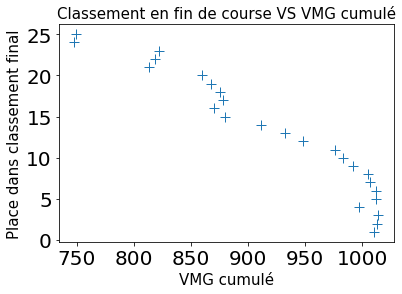

In [1451]:
f=plt.figure()
plt.plot(DF['VMGc'],DF['Rang'],marker='+',linestyle='None',markersize='10')
plt.xlabel('VMG cumulé',fontsize=15)
plt.ylabel('Place dans classement final',fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Classement en fin de course VS VMG cumulé',fontsize=15)
plt.show()

On observe donc bien qu'une VMG cumulé indique une meilleur place dans le classement. Pour autant, pour des VMG cumulé similaires, on observe que cette tendance est moins marqué. On illustre cette observtion en ne gardant du graphique précédent que les relevés des 8 premiers. 

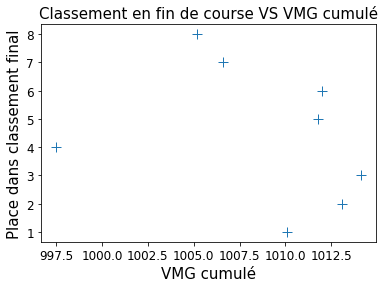

In [1473]:
df=DF[DF['Rang']<=8]
plt.plot(df['VMGc'],df['Rang'],marker='+',linestyle='None',markersize='10')
plt.xlabel('VMG cumulé',fontsize=15)
plt.ylabel('Place dans classement final',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Classement en fin de course VS VMG cumulé',fontsize=15)
plt.legend
plt.show()

On remarque bien l'abscence de corrélation dans ce dernier graphique.